In [5]:
import os

# --- Add these lines at the very top of your script ---
# This must be done BEFORE importing numpy or other scientific libraries.
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'

import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import time
from device import Device
from device import Device
from rgf import GreensFunction
import scipy as sp
from hamiltonian import Hamiltonian
from helper import Helper_functions
import scipy.sparse as spa
import numpy as np
import scipy.sparse as sp
from lead_self_energy import LeadSelfEnergy
from scipy.sparse import bmat, identity, random, csc_matrix
from scipy.sparse.linalg import eigsh, eigs, spsolve
import time
from NEGF_unit_generation import UnitCell


In [2]:
# Test code to isolate dangling bond effects
dev = Device(2.5e-9, 1.5e-9)
ham = Hamiltonian(dev)

# Create unit cell with dangling bonds
unit_cell = UnitCell(dev.unitZ, dev.unitX, orientiation=(0, 1, 2, 3), not_NEGF=True)

# Create Hamiltonian WITHOUT potential correction
H = ham.create_sparse_channel_hamlitonian(ky=0, blocks=False, unitCell=unit_cell)

# Check eigenvalues
eigvals, eigvecs = spa.linalg.eigsh(H, k=max(50, H.shape[0]-2), which='LM')
eigvals = np.sort(eigvals.real)

# Look for bandgap
print("Eigenvalues around Fermi level:")
for i, val in enumerate(eigvals):
    if -5 < val < 5:  # Look around Fermi level
        print(f"E{i}: {val:.3f} eV")

Eigenvalues around Fermi level:
E77: -4.794 eV
E78: -4.681 eV
E79: -4.561 eV
E80: -4.554 eV
E81: -4.545 eV
E82: -4.506 eV
E83: -4.483 eV
E84: -4.409 eV
E85: -4.404 eV
E86: -4.333 eV
E87: -4.315 eV
E88: -4.300 eV
E89: -4.234 eV
E90: -4.083 eV
E91: -4.063 eV
E92: -4.036 eV
E93: -4.008 eV
E94: -3.998 eV
E95: -3.983 eV
E96: -3.949 eV
E97: -3.914 eV
E98: -3.897 eV
E99: -3.815 eV
E100: -3.788 eV
E101: -3.778 eV
E102: -3.763 eV
E103: -3.739 eV
E104: -3.720 eV
E105: -3.695 eV
E106: -3.675 eV
E107: -3.563 eV
E108: -3.553 eV
E109: -3.523 eV
E110: -3.506 eV
E111: -3.444 eV
E112: -3.441 eV
E113: -3.414 eV
E114: -3.390 eV
E115: -3.346 eV
E116: -3.331 eV
E117: -3.313 eV
E118: -3.306 eV
E119: -3.293 eV
E120: -3.286 eV
E121: -3.255 eV
E122: -3.247 eV
E123: -3.229 eV
E124: -3.212 eV
E125: -3.183 eV
E126: -3.147 eV
E127: -3.137 eV
E128: -3.067 eV
E129: -3.006 eV
E130: -2.995 eV
E131: -2.986 eV
E132: -2.959 eV
E133: -2.911 eV
E134: -2.886 eV
E135: -2.843 eV
E136: -2.830 eV
E137: -2.787 eV
E138: -2.768 eV

In [19]:

eta = 1e-6  # Small broadening parameter for numerical stability



def test_GR(E):
    dev = Device(2e-9, 1e-9)
    ham = Hamiltonian(dev)
    lse = LeadSelfEnergy(device=dev, hamiltonian=ham)
    ky = 0
    H = ham.create_sparse_channel_hamlitonian(ky, blocks=False)
    sl, sr = lse.self_energy("left", E=E, ky=ky), lse.self_energy("right", E=E, ky=ky)
    H[:ham.Nz * 10, :ham.Nz * 10] += sl
    H[-ham.Nz * 10:, -ham.Nz * 10:] += sr
    # Add small imaginary part to energy
    E_complex = E #+ 1j * eta

    # Construct Green's function: G(E) = (E*I - H)^(-1)
    H_gf = csc_matrix(np.eye(H.shape[0], dtype=complex) * E_complex) - H
    I = csc_matrix(np.eye(H.shape[0], dtype=complex))

    # Solve for Green's function
    G_R = spsolve(H_gf, I)
    return G_R


E = np.linspace(-30,20, 1000)
dE = E[1]-E[0]
H = ham.create_sparse_channel_hamlitonian(0, blocks=False)
# Calculate G_R integrated over energy using multiprocessing
G_R_integrated = np.zeros((H.shape[0], H.shape[0]), dtype=complex)

print(f"Integrating Green's function over {len(E)} energy points using multiprocessing...")
start_time = time.time()

# Use multiprocessing to parallelize the calculation
with multiprocessing.Pool(processes=32) as pool:
    G_R_results = pool.map(test_GR, (E + 1e-6j))

# Sum all the Green's function matrices
for G_R in G_R_results:
    G_R_integrated += G_R * dE

end_time = time.time()
print(f"Integration completed in {end_time - start_time:.2f} seconds")
print(f"Integrated G_R matrix shape: {G_R_integrated.shape}")


Integrating Green's function over 1000 energy points using multiprocessing...


/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j,

Integration completed in 30.19 seconds
Integrated G_R matrix shape: (560, 560)


In [20]:
G_R_integrated

matrix([[-3.77147736-4.81513818e-03j, -0.31585636+1.34036817e-02j,
         -1.06707261+1.44457683e-03j, ...,  1.46145004+6.09761502e-02j,
         -0.84701923-1.10101455e-02j, -0.4176212 -1.91239047e-02j],
        [ 1.43746969-8.19455191e-04j, -2.20613061-5.59705069e-03j,
          0.90670601-1.52837154e-03j, ...,  1.48363131-2.55202799e-02j,
         -3.83220127+9.49273294e-03j,  2.04487666+6.48810838e-03j],
        [ 1.72927421-1.66939174e-04j,  0.03983977-8.69995100e-03j,
         -1.64345422-2.31580928e-03j, ...,  1.76202129-3.53937159e-02j,
         -3.23691469+8.34061763e-03j,  1.95547736+1.00331254e-02j],
        ...,
        [ 0.2875952 -4.57284388e-03j, -1.86755791+9.79312732e-03j,
          0.0420726 -2.03584658e-03j, ...,  2.79183237+8.03799747e-02j,
         -2.43083249-4.39881802e-02j, -4.28550235-2.36323560e-02j],
        [ 0.73237626+2.17093429e-03j, -3.65500755-9.63665496e-03j,
         -1.61713104-3.86805355e-03j, ...,  2.29196439-1.00485065e-02j,
         -8.70633948

In [23]:
500000j * test_GR(500000j).toarray()

/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


array([[ 9.99999999e-01-1.56966400e-05j, -6.06109121e-11+1.47448758e-15j,
        -6.06109121e-11+1.47448403e-15j, ...,
         6.18911859e-70+1.22767276e-66j,  1.69443048e-70+4.16474791e-67j,
         7.10412297e-69+1.28902790e-65j],
       [-6.06109121e-11+1.47448758e-15j,  9.99999999e-01-2.84584999e-05j,
         1.09860896e-09+1.99999999e-05j, ...,
         8.86770025e-70+1.68637882e-66j,  2.49564695e-70+5.79695632e-67j,
         1.01548389e-68+1.77154620e-65j],
       [-6.06109121e-11+1.47448403e-15j,  1.09860896e-09+1.99999999e-05j,
         9.99999999e-01-2.84584999e-05j, ...,
         7.15017704e-70+1.36493036e-66j,  2.00261514e-70+4.67879461e-67j,
         8.22341911e-69+1.44462874e-65j],
       ...,
       [ 6.18911859e-70+1.22767276e-66j,  8.86770025e-70+1.68637882e-66j,
         7.15017704e-70+1.36493036e-66j, ...,
         9.99999999e-01-2.75790000e-05j, -3.38309079e-22+7.43321385e-22j,
         1.13225379e-21-7.46215193e-21j],
       [ 1.69443048e-70+4.16474791e-67j,  2.

Starting DOS calculations for 1250 (E, ky) pairs...
Energy range: -2.00 to 3.00 eV
ky range: 0.00 to 1.00


/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/nandan_diwan/Desktop/NEGF_sim/.venv/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j,

Calculations finished in 98.44 seconds.
Valid results: 1250/1250
DOS calculation complete. Energy points: 50


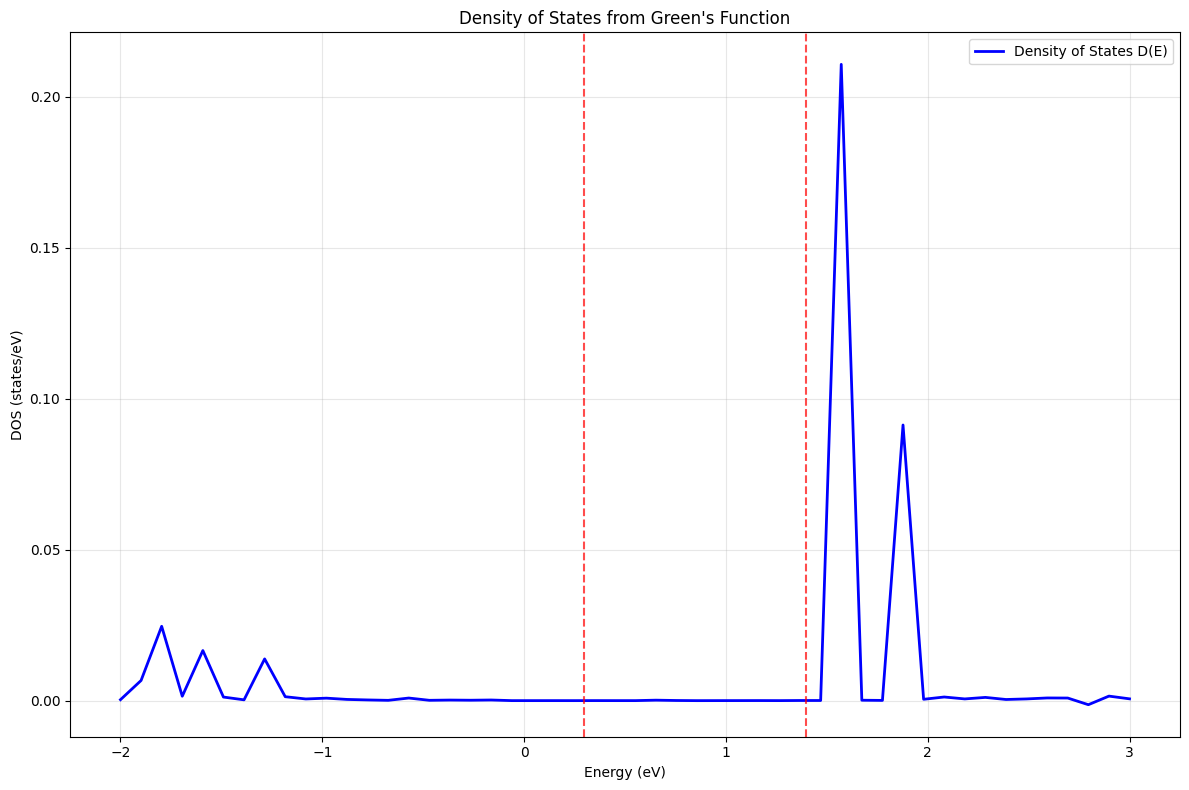

In [ ]:
def DOS(param): 
    E, ky = param
    eta = 1e-6  # Small broadening parameter for numerical stability
    
    dev = Device(2e-9, 1e-9)
    ham = Hamiltonian(dev)
    lse = LeadSelfEnergy(device=dev, hamiltonian=ham)
    #unit_cell = UnitCell(dev.unitZ, dev.unitX, orientiation=(0, 1, 2, 3), not_NEGF=True)
    
    H = ham.create_sparse_channel_hamlitonian(ky, blocks=False)
    sl, sr = lse.self_energy("left", E=E, ky=ky), lse.self_energy("right", E=E, ky=ky)
    H[:ham.Nz * 10, :ham.Nz * 10] += sl
    H[-ham.Nz * 10:, -ham.Nz * 10:] += sr
    # Add small imaginary part to energy
    E_complex = E + 1j * eta
    
    # Construct Green's function: G(E) = (E*I - H)^(-1)
    H_gf = csc_matrix(np.eye(H.shape[0], dtype=complex) * E_complex) - H
    I = csc_matrix(np.eye(H.shape[0], dtype=complex))
    
    # Solve for Green's function
    G_R = spsolve(H_gf, I)
    
    # DOS = -(1/π) * Im[Tr(G_R(E))]
    dos = -1/np.pi * np.imag(G_R.trace())
    
    return (E, ky, dos)

# Use a wider energy range to capture the full band structure
energy_values = np.linspace(-2, 3, 50)  # Wider range, more points
ky_values = np.linspace(0, 1.0, 25)     # More ky points for better k-space sampling
dk = ky_values[1] - ky_values[0]

param_grid = list(product(energy_values, ky_values))

print(f"Starting DOS calculations for {len(param_grid)} (E, ky) pairs...")
print(f"Energy range: {energy_values[0]:.2f} to {energy_values[-1]:.2f} eV")
print(f"ky range: {ky_values[0]:.2f} to {ky_values[-1]:.2f}")

start_time = time.time()

with multiprocessing.Pool(processes=32) as pool:
    results = pool.map(DOS, param_grid)
    
end_time = time.time()
print(f"Calculations finished in {end_time - start_time:.2f} seconds.")

# Aggregate traces for each energy value (sum over all ky values)
energy_traces = defaultdict(float)
valid_results = 0

for energy, ky, dos_val in results:
    if not (np.isnan(dos_val) or np.isinf(dos_val)):
        energy_traces[energy] += dos_val
        valid_results += 1
    else:
        print(f"Invalid result at E={energy:.3f}, ky={ky:.3f}: {dos_val}")

print(f"Valid results: {valid_results}/{len(results)}")

# Sort energies and calculate final DOS
dos_energies = sorted(energy_traces.keys())

# For 2D system, multiply by k-space integration factor
# The factor dk/(2π) accounts for the k-space sampling
dos_values = []
for E in dos_energies:
    dos_val = energy_traces[E] * (dk / (2 * np.pi))
    dos_values.append(dos_val)

print(f"DOS calculation complete. Energy points: {len(dos_energies)}")

# Plotting the Density of States
plt.figure(figsize=(12, 8))

plt.plot(dos_energies, dos_values, 'b-', linewidth=2, label='Density of States D(E)')
plt.xlabel('Energy (eV)')
plt.ylabel('DOS (states/eV)')
plt.title('Density of States from Green\'s Function')
plt.grid(True, alpha=0.3)
plt.legend()

# Add vertical lines to show bandgap
plt.axvline(x=0.296, color='r', linestyle='--', alpha=0.7, label='Band edge')
plt.axvline(x=1.396, color='r', linestyle='--', alpha=0.7, label='Band edge')

plt.tight_layout()
plt.savefig("dos.png", dpi=300, bbox_inches='tight')
plt.show()

# Save data for further analysis
np.savetxt("dos_data.txt", np.column_stack([dos_energies, dos_values]), 
            header="Energy(eV)\tDOS(states/eV)", fmt="%.6e")

In [7]:
DOS((2,0))

(2, 0, np.float64(-0.0))

In [ ]:
from poisson import PoissonSolver

poissonSolver = PoissonSolver(device)

In [ ]:
poissonSolver.solve_poisson_equation()



In [ ]:
device = Device()
ham = Hamiltonian(device)
rgf = GreensFunction(device, ham)

G_R, gamma1, gamma2, sigmaL, sigmaR= rgf.sparse_rgf_G_R(E=0.1, ky = 0.1)


In [ ]:
print(G_R[0].shape)

In [ ]:
time_start = time.time()
dagger = lambda A: np.conjugate(A.T)
side = "left"
Hpp_matrices = [None] * lead.P
HpP_matrices = [None] * lead.P
hPP,hPP1 = lead.get_layer_hamiltonian(lead.P, side)

HPP = Helper_functions.sparse_inverse(spa.csc_matrix(lead.E * np.eye(hPP.shape[0]) - hPP))
Hpp_matrices[-1], HpP_matrices[-1] = HPP, HPP
for i in range(lead.P - 1, 0, -1):
    
    hpp, hpp1 = lead.get_layer_hamiltonian(i, side)
    Hpp = Helper_functions.sparse_inverse(spa.csc_matrix(lead.E * np.eye(hPP.shape[0]) - \
        hpp - hpp1 @ Hpp_matrices[i] @ dagger(hpp1)))
    Hpp_matrices[i - 1] = Hpp
    HpP = Hpp_matrices[i - 1] @ hpp1 @ HpP_matrices[i]
    HpP_matrices[i - 1] = HpP
    
C22 = Hpp_matrices[1]
C2P = HpP_matrices[1]
C_matrices = [None] * 4
C_matrices[1] = C22
for p in range(3, lead.P + 1):
    hpp, hpp1 = lead.get_layer_hamiltonian(i, side)
    C_matrices[p - 1] = Hpp_matrices[p - 1] + Hpp_matrices[p -1] @ (hpp1 @ C_matrices[p -2] @ dagger(hpp1)) @ Hpp_matrices[p - 1] 

h11, h12 = lead.get_layer_hamiltonian(1, side)

XIs = h11 + h12 @ C_matrices[1] @ dagger(h12)
XI = XIs + dagger(hPP1) @ C_matrices[-1] @ hPP1
PI = h12 @ C2P @ hPP1





In [ ]:
XIs = spa.csc_matrix(XIs)
XI = spa.csc_matrix(XI)
PI = spa.csc_matrix(PI)
I = np.eye(XI.shape[0], dtype=XI)
Z = I * 0
D = lead.E * I.copy() - XI
T = -PI

A = bmat([
    [Z, I],
    [-T.conj().T, -D]
], format='csc')

B = bmat([
    [I, Z],
    [Z, T]
], format='csc')

eigenvalues, eigenvectors = eigs(A, M=B, sigma=1.0, which='LM')




def construct_U_plus_and_Lambda_plus(eigenvalues, eigenvectors, n_dim, epsilon=0.1):
    abs_vals = np.abs(eigenvalues)
    

    is_propagating = np.isclose(abs_vals, 1.0)
    is_evanescent = (abs_vals < 1.0) & (abs_vals > epsilon)
    
    selected_indices = np.where(is_propagating | is_evanescent)[0]
    
    if len(selected_indices) == 0:
        return np.array([], dtype=complex), np.array([],dtype=complex)
        
    filtered_eigenvalues = eigenvalues[selected_indices]
    filtered_eigenvectors = eigenvectors[:, selected_indices]

    Lambda_plus = np.diag(filtered_eigenvalues)
    U_plus = filtered_eigenvectors[:n_dim, :]

    return U_plus, Lambda_plus

U_plus, Lambda = construct_U_plus_and_Lambda_plus(eigenvalues, eigenvectors, T.shape[0], epsilon=0.1)

U_pseudo = np.linalg.pinv(U_plus)
F = U_plus @ Lambda @ U_pseudo

Y = np.linalg.solve(lead.E * I - XIs.toarray() - PI.toarray() @ F, dagger(h12.toarray()))
self_energy = h12 @ Y
time_end = time.time()
print(f"time is: {time_end - time_start}")

In [ ]:
print(self_energy)

In [ ]:
H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=True)
print(H00)

In [ ]:
H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=False)
print(H00)

In [ ]:
def surface_gf(Energy, H00, H10, tol=1e-6): 
    """ 
    This iteratively calculates the surface green's function for the lead based. 
    Although it is tested for 1D, it should be good for 2D surfaces. 
    """

    Energy = Energy
    dagger = lambda A: np.conjugate(A.T)
    
    I = np.eye(H00.shape[0], dtype=complex)
    H01 = dagger(H10)

    epsilon_s = H00.copy()
    epsilon = H00.copy()
    alpha = H01.copy()
    beta = dagger(H10).copy()
    err = 1.0
    first_time = True

    while err > tol:
        if first_time:
            inv_E = Helper_functions.sparse_inverse(spa.csr_matrix(Energy * I) - spa.csr_matrix(epsilon))
            first_time = False
        else:

            inv_E = np.linalg.solve(Energy * I - epsilon, I)
    
        epsilon_s_new = epsilon_s + alpha @ inv_E @ beta
        epsilon_new = epsilon + beta @ inv_E @ alpha + alpha @ inv_E @ beta
        alpha_new = alpha @ inv_E @ alpha
        beta_new = beta @ inv_E @ beta

        err = np.linalg.norm(alpha_new, ord='fro')

        epsilon_s, epsilon, alpha, beta = epsilon_s_new, epsilon_new, alpha_new, beta_new

    return  np.linalg.solve(Energy * I - epsilon_s, I)
H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=True)


surface_gf(0, H00, H10, tol=1e-3)

In [ ]:
def surface_gf(Energy, H00 : np.ndarray, H10: np.ndarray, tol=1e-6): 
    """ 
    This iteratively calculates the surface green's function for the lead based. 
    Although it is tested for 1D, it should be good for 2D surfaces. 
    """
    
    Energy = Energy
    dagger = lambda A: np.conjugate(A.T)
    
    I = np.eye(H00.shape[0], dtype=complex)
    H01 = dagger(H10)

    epsilon_s = H00.copy()
    epsilon = H00.copy()
    alpha = H01.copy()
    beta = dagger(H10).copy()
    err = 1.0

    while err > tol:
        inv_E = np.linalg.solve(Energy * I - epsilon, I)

        epsilon_s_new = epsilon_s + alpha @ inv_E @ beta
        epsilon_new = epsilon + beta @ inv_E @ alpha + alpha @ inv_E @ beta
        alpha_new = alpha @ inv_E @ alpha
        beta_new = beta @ inv_E @ beta

        err = np.linalg.norm(alpha_new, ord='fro')

        epsilon_s, epsilon, alpha, beta = epsilon_s_new, epsilon_new, alpha_new, beta_new

    return  np.linalg.solve(Energy * I - epsilon_s, I)

H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=False)

surface_gf(0, H00, H10)

In [ ]:
from helper import Helper_functions

H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=True)
print(H00)
Helper_functions.sparse_inverse(-H00)
H00,H10 = device.hamiltonian.get_H00_H01(ky=0.1, sparse=False)
print(H00)
Helper_functions.sparse_inverse(-H00)

In [ ]:
H = device.hamiltonian.create_sparse_hamlitonian(0.1)